# Spike inference from Calcium imaging data with CASCADE

**CASCADE**, short for Calibrated spike inference from calcium imaging data using deep networks, is an open-source, deep learning-based pipeline for inferring neuronal spike trains from calcium imaging data. It provides robust and calibrated spike inference by leveraging ground truth datasets and convolutional neural networks, enabling the reconstruction of neuronal spiking activity from noisy or slow calcium fluorescence signals.  

![gif](images/CA1_deconvolution_CASCADE.gif "CASCADE translates calcium imaging ΔF/F traces into spiking probabilities or discrete spikes.")
**Figure 1:** CASCADE translates calcium imaging $\Delta F/F$ traces into spiking probabilities or discrete spikes. Source: [CASCADE GitHub repository](https://github.com/HelmchenLabSoftware/Cascade/tree/master) (license: MIT License)


CASCADE operates by first training on large-scale ground truth data, then applying a pre-trained or custom model to new experimental calcium traces, thereby generating probabilistic or discrete spike estimates.  

The approach is particularly valuable for neuroscience experiments where direct electrophysiological recordings are impractical, and offers a standardized, reproducible method for analyzing large calcium imaging datasets.


**Acknowledgment:**  
This script is entirely based on the [official demo](https://github.com/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Calibrated_spike_inference_with_Cascade.ipynb) provided by the [CASCADE team](https://github.com/HelmchenLabSoftware/Cascade/tree/master), with modifications for use in the present course. Original code by [Peter Rupprecht](https://github.com/PTRRupprecht) and [Adrian Hoffmann](https://github.com/AdrianHoffmann), [Helmchen Lab](https://www.hifo.uzh.ch/en/research/helmchen.html), in collaboration with the [Friedrich Lab](https://www.fmi.ch/research-groups/groupleader.html?group=119).

All credit for the original development and maintenance of CASCADE belongs to the authors. For scientific use, please cite the following publication:

**Rupprecht et al., "A database and deep learning toolbox for noise-optimized, generalized spike inference from calcium imaging," *Nature Neuroscience* (2021), [https://doi.org/10.1038/s41593-021-00895-5](https://doi.org/10.1038/s41593-021-00895-5)**.

Please refer to the [CASCADE GitHub repository](https://github.com/HelmchenLab/Cascade) for the latest updates, documentation, and contact information. Feedback regarding this adaptation may be directed to the course instructor; questions about CASCADE itself should be addressed to [Peter Rupprecht](mailto:p.t.r.rupprecht+cascade@gmail.com).

## Installation

### Create a conda environment with CASCADE
First, we need to create a conda environment with the required packages. CASCADE offers [instructions](https://github.com/HelmchenLabSoftware/Cascade/tree/master#getting-started) for different platforms, including Windows, macOS, and Linux, with and without GPU support:

#### PC (Windows/Linux) with GPU support
For a GPU installation (faster, recommended if you will train networks):

```bash
mamba create -n cascade python=3.7 tensorflow-gpu keras h5py numpy scipy matplotlib seaborn ruamel.yaml ipykernel ipython -c conda-forge -c anaconda -y
mamba activate cascade
```

#### PC (Windows/Linux) without GPU support
For a CPU installation (slower, recommended if you will not train a network):

```bash
mamba create -n cascade python=3.7 tensorflow keras h5py numpy scipy matplotlib seaborn ruamel.yaml ipykernel ipython -c conda-forge -c anaconda -y
mamba activate cascade
```

#### MacOS with GPU support
I've recently tested this on a MacBook Pro with an M1 chip, using macOS Sequoya 15.5, and it worked perfectly:

```bash
mamba create -n cascade_2025 -y python=3.8 tensorflow keras h5py numpy scipy matplotlib seaborn ruamel.yaml ipykernel ipython -c conda-forge -c anaconda -y
mamba activate cascade_2025
mamba install -c apple tensorflow-deps
pip install tensorflow-macos tensorflow-metal
```

### Download the CASCADE repository
CASCADE is not available on PyPI, so you need to download the repository from GitHub. The Github repository contains all custom functions, the ground truth datasets and the pre-trained models. To do so, you have two options:

#### Option 1: Download the repository as a ZIP file
You can download the repository as a ZIP file from the [CASCADE GitHub page](https://github.com/HelmchenLabSoftware/Cascade/tree/master). After downloading, extract the ZIP file to the tutorial folder `02 Cascade tutorial` in the course directory.

#### Option 2: Clone the repository using Git
If you have Git installed, you can clone the repository directly into the tutorial folder using the following Python command:

In [3]:
# download Cascade if not present (this may take a while):
import os
if "02 Cascade tutorial" in os.getcwd():
    if not os.path.exists('Cascade'):
        print("Cascade directory not found. Cloning the repository...")
        !git clone https://github.com/HelmchenLabSoftware/Cascade
        print("Cascade repository cloned successfully.")
    else:
        print("Cascade directory already exists.")
    os.chdir('Cascade')
    print(f"Changed directory to {os.getcwd()}")

Cascade directory already exists.
Changed directory to /Users/husker/Science/Python/Projekte/Ca Image Analysis Course/02 Cascade tutorial/Cascade


## Relation between action potentials and calcium transients
The **action potential** is the fundamental electrical event by which neurons communicate. It is a brief, stereotyped change in membrane potential, initiated when synaptic input or external stimulation depolarizes the membrane beyond a threshold.

![img](images/action_potential2.png "The phases of an Action Potential.")
**Figure 2:** Stages of an action potential. Source: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Action_potential.svg) (license: CC BY-SA 3.0; modified)

**Phases of the action potential:**

* **Depolarization:** Voltage-gated sodium (Na⁺) channels open, allowing Na⁺ influx and a rapid rise of the membrane potential (from typically −70 mV to +30 mV).
* **Repolarization:** Sodium channels inactivate; voltage-gated potassium (K⁺) channels open, K⁺ exits the cell, and the membrane potential falls back.
* **Hyperpolarization:** As K⁺ channels close slowly, the membrane potential briefly undershoots its resting value.

The entire electrical event lasts **\~1–2 milliseconds**. However, a key link to functional imaging comes from **voltage-gated calcium (Ca²⁺) channels**, which open during the depolarization (and sometimes early repolarization) phase — most notably at axon terminals and in certain somatic/dendritic compartments. This results in a **brief but significant influx of Ca²⁺ ions** into the neuron.

**Calcium transient:**  

The influx of Ca²⁺ produces a **transient rise in intracellular calcium concentration**. The amplitude and time course of this transient depend on:

* The number and timing of action potentials.
* The local density and subtype of Ca²⁺ channels.
* Cellular buffering, extrusion mechanisms, and compartment geometry.

**Temporal relationship:**

* **Action potential:** Rapid (**1–2 ms**, all-or-none, digital signal).
* **Ca²⁺ transient:** Slower (**10–100 ms or more**), reflecting biological Ca²⁺ handling.
* **Measured fluorescence:** Even slower, because the optical signal reflects both the underlying Ca²⁺ dynamics and the **kinetics of the chosen indicator** (e.g., GCaMP variants, OGB-1, Fluo-4).

**Why do indicator kinetics matter?**

* **Fast indicators** (e.g., GCaMP6f) have rapid binding/unbinding and better temporal fidelity, but may have lower signal amplitude.
* **Slow indicators** (e.g., GCaMP6s) bind Ca²⁺ for longer, producing larger, longer-lasting signals but greater temporal blurring.
* The **recorded fluorescence trace** is thus a **convolution** of the cell's true Ca²⁺ dynamics and the indicator's own response, resulting in a signal that rises and decays much more slowly than the action potential that triggered it.

**Does the fluorescence decay match the true Ca²⁺ decay?**

* **Not exactly.** The decay time of the recorded signal is generally longer than the underlying Ca²⁺ transient because it includes both **biological clearance** and **indicator off-kinetics**.
* For this reason, fast and slow indicators exist: to balance **sensitivity** against **temporal resolution**, depending on experimental goals.

**Summary table:**

| Event | Typical time course | Notes |
| ----------- | ------------ | ------ |
| Action potential | **1–2 ms** | Electrical event (Na⁺/K⁺ channels)       |
| Ca²⁺ influx & clearance         | **10–100 ms** (rise/decay)   | Biological, varies with cell/compartment |
| Indicator fluorescence response | **50 ms – 1 s** (rise/decay) | Convolution of Ca²⁺ + indicator kinetics |

**Analytical implication:**  

Calcium imaging does **not** measure action potentials directly, but a **filtered, noisy, and temporally blurred proxy**—the fluorescence signal of the indicator bound to Ca²⁺. The lack of strict one-to-one correspondence means:

* **Not every spike produces a clearly separable calcium transient** (especially at high firing rates or with slow indicators).
* **Some calcium transients represent the cumulative effect of multiple spikes.**
* **Noise, baseline drift, and kinetics** can obscure single events.

This biophysical chain underlies the need for careful **spike inference algorithms**: reconstructing the underlying spike train from the slow, convolved, and noisy optical signal, given known indicator properties and the basic principles of cellular calcium dynamics.


## Import required python packages

In [1]:
# standard python packages
import warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')
warnings.filterwarnings('ignore')

In [4]:
# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

	YAML reader installed (version 0.18.6).
	Keras installed (version 2.13.1).
	Tensorflow installed (version 2.13.0).


## Load a sample data set of $\Delta F/F$ traces
We begin this tutorial with some sample data provided by CASCADE. CASCADE generally expects the traces to be saved as a single large 2D NumPy array, where each row corresponds to a neuron and each column corresponds to a time point (neurons $\times$ time, thus, `(neurons, time)`). The $\Delta F/F$ values stored therein should be numeric, not in percent (e.g. 0.5 instead of 50%).

To load the sample data, we need to define a function which handles `.npy` and `.mat` files (the format used by the sample datasets distributed with CASCADE). This function will read the data and return it as a 2D NumPy array.

**ℹ️ Info:** If your own data is already in the correct array format, you can skip the usage of this function and use your array directly.

In [5]:
def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""

    if file_path.endswith('.mat'):
      traces = sio.loadmat(file_path)['dF_traces']
      # PLEASE N­OTE: If you use mat73 to load large *.mat-file, be aware of potential numerical errors, see issue #67 (https://github.com/HelmchenLabSoftware/Cascade/issues/67)

    elif file_path.endswith('.npy'):
      traces = np.load(file_path, allow_pickle=True)
      # if saved data was a dictionary packed into a numpy array (MATLAB style): unpack
      if traces.shape == ():
        traces = traces.item()['dF_traces']

    else:
      raise Exception('This function only supports .mat or .npy files.')

    print('Traces standard deviation:', np.nanmean(np.nanstd(traces,axis=1)))
    if np.nanmedian(np.nanstd(traces,axis=1)) > 2:
      print('Fluctuations in dF/F are very large, probably dF/F is given in percent. Traces are divided by 100.')
      return traces/100
    else:
        return traces


Next, we load a sample data set provided by CASCADE. The dataset contains calcium imaging data from a mouse visual cortex, with ground truth spike trains available for comparison. The data is stored in a `.mat` file, which we will load using the function defined above. We also need to specify the **frame rate** of the calcium imaging data, which is required for the spike inference process.

In [6]:
example_file = "Example_datasets/Allen-Brain-Observatory-Visual-Coding-30Hz/Experiment_552195520_excerpt.mat"
frame_rate = 30 # fps

# check and load the example file:
try:
  traces = load_neurons_x_time( example_file )
  print('Number of neurons in dataset:', traces.shape[0])
  print('Number of timepoints in dataset:', traces.shape[1])
except Exception as e:
  print('\nSomething went wrong!\nEither the target file is missing, in this case please provide the correct location.\nOr your file is not yet completely uploaded, in this case wait until the upload is completed.\n')
  print('Error message: '+str(e))

Traces standard deviation: 0.079336
Number of neurons in dataset: 74
Number of timepoints in dataset: 6001


In [ ]:
# THIS CELL/STEP IS RESERVED FOR THE EXERCISE
# overwrite traces by your own data:
traces = my_traces

Let's investigate the shape of the loaded data to ensure it is in the correct format:

In [7]:
print(f"shape of dF/F traces: {traces.shape}")

shape of dF/F traces: (74, 6001)


The shape (74, 6001) = (neurons $\times$ time) indicates that we have 74 neurons and 6001 time points. So, everything is as expected. Let's plot the trace of the first neuron to see what it looks like:

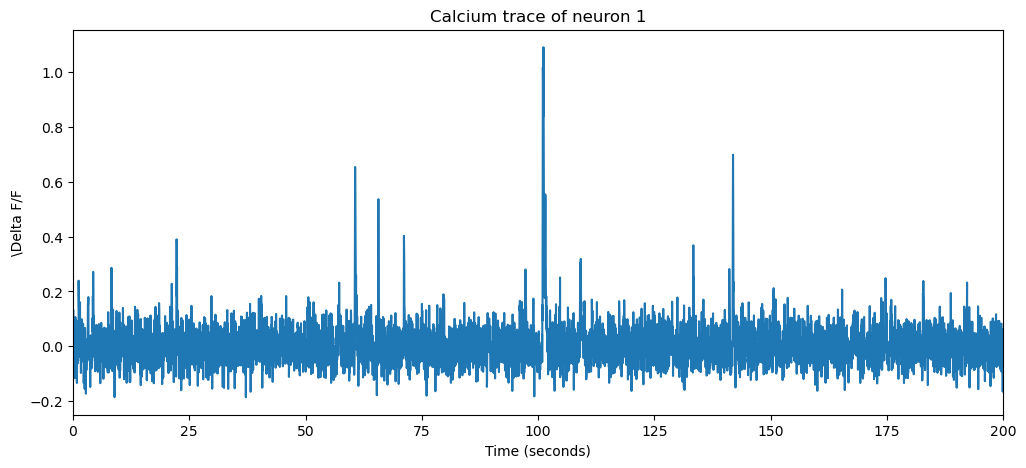

In [15]:
# define the neuron index to plot:
neuron_i = 0

import seaborn 

# define a time array based on the frame_rate:
time_vector = np.arange(traces.shape[1]) / frame_rate

# plot the calcium trace for the selected neuron:
plt.figure(figsize=(12, 5))
plt.plot(time_vector, traces[neuron_i, :])
plt.xlabel('Time (seconds)')
plt.ylabel(f'\Delta F/F')
plt.xlim(0, time_vector[-1])
plt.title(f'Calcium trace of neuron {neuron_i + 1}')
plt.show()

**Exercise:** Plot some other traces to see how they look like. What do you notice? 

Instead of plotting a single trace on "our own", we can use CASCADE's plotting functions to visualize the traces. This is useful for quickly checking the data quality and understanding the overall structure of the dataset. Here is how you can plot randomly some selected calcium traces:

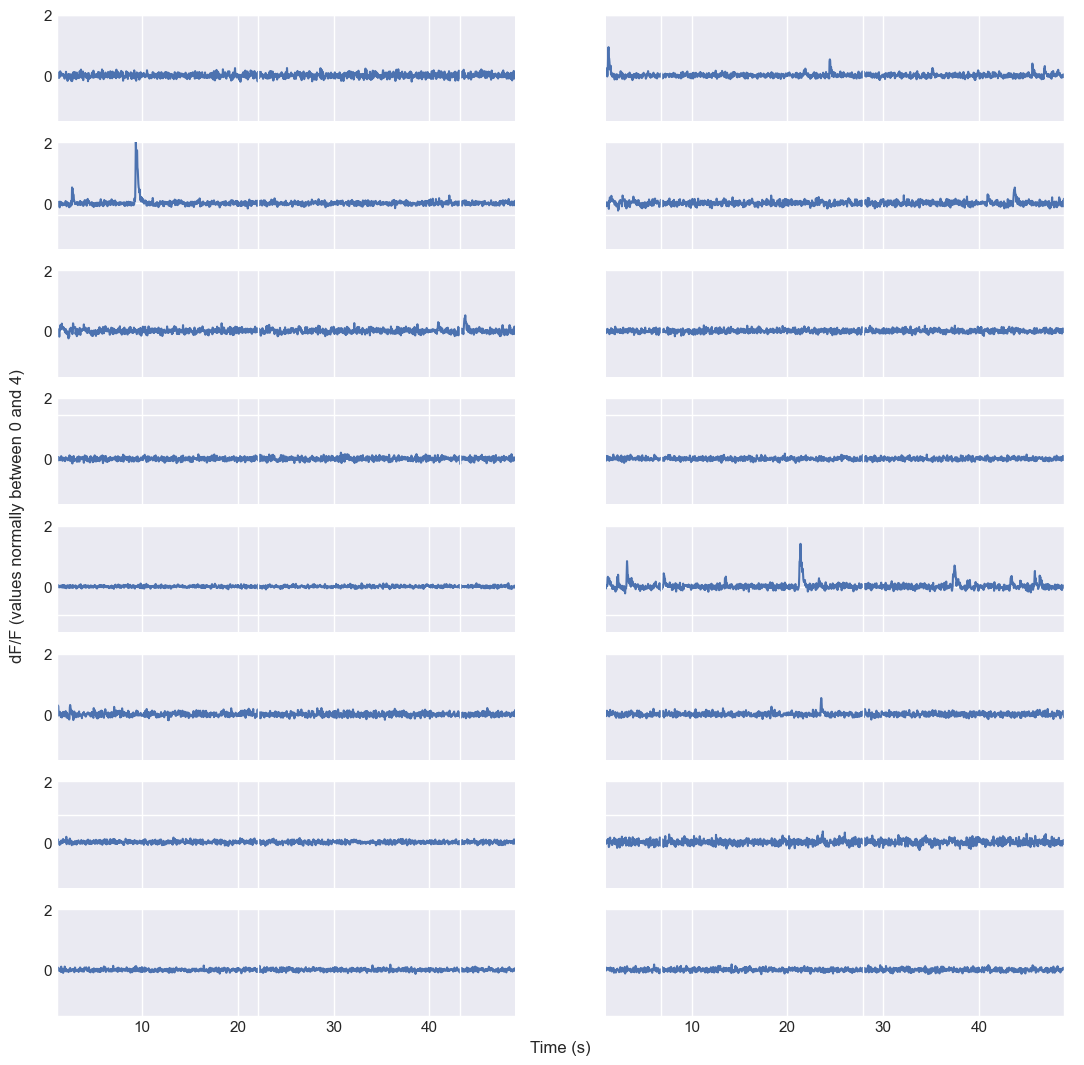

In [16]:
plt.rcParams['figure.figsize'] = [13, 13]
np.random.seed(0)  # for reproducibility
neuron_indices = np.random.randint(traces.shape[0], size=16)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate)

Plotting random traces helps to check whether the data have been loaded correctly. If you want to plot specific instead of randomly selected neurons, modify the variable `neuron_indices` accordingly.

## Plot distribution of noise levels
The traces are quite noisy, which is typical for calcium imaging data. 


In calcium imaging analysis, the noise level is a quantitative measure of the baseline variability (fluctuations not caused by neural activity) in each neuron's fluorescence trace. It is usually given as a standard deviation (or a related metric) of the trace's background fluctuations, normalized by the signal amplitude and frame rate. CASCADE offers a method to estimate the noise level of the traces:

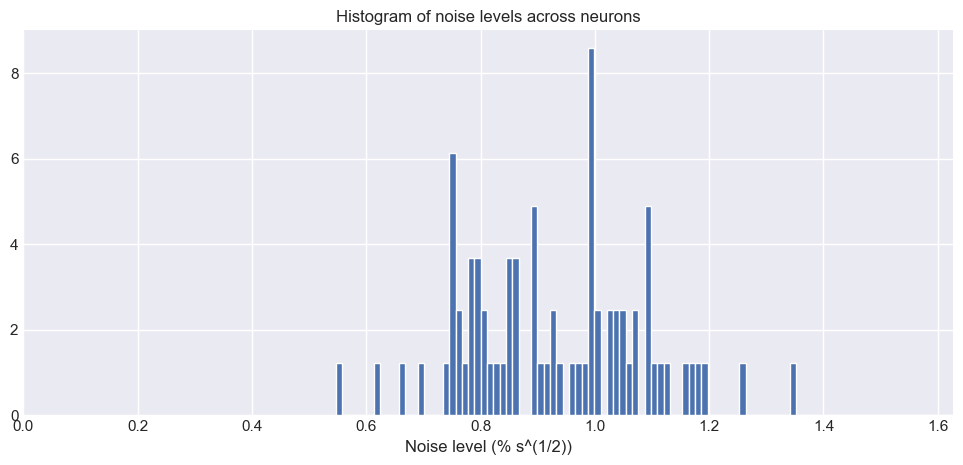

In [17]:
#@markdown For each neuron in the loaded dataset, the noise level will be computed and the 
# distribution across neurons will be shown.

plt.rcParams['figure.figsize'] = [12, 5]
noise_levels = plot_noise_level_distribution(traces, frame_rate)

### What does the noise level mean?
* **Low noise level:** The fluorescence trace has little baseline fluctuation, meaning genuine calcium transients (spikes) stand out more clearly.
* **High noise level:** The trace is "noisier", i.e., there are larger random fluctuations not related to neuronal activity, making it harder to reliably detect true events.

### Why is this important?
* **Quality control:** The distribution of noise levels across neurons allows you to assess the overall quality of your dataset. A narrow, low-centered distribution means your data is generally "clean"; a wide or high-centered distribution suggests variable or poor signal quality.
* **Spike inference performance:** The performance of any spike inference algorithm (including CASCADE) is fundamentally limited by the noise level:
  * Low-noise traces allow more accurate spike detection.
  * High-noise traces may lead to missed spikes (false negatives) or false positives.
* **Network training and calibration:** CASCADE uses the noise level to select or train an appropriate deep learning model for spike inference, since the ground truth datasets and models are stratified by noise level. For optimal performance, the noise distribution of your data should match that of the ground truth set used to train the model.

### What does our noise level histogram tell us?
The histogram above shows how the noise levels are distributed across all neurons in our dataset.

* **Peak location:** Indicates the typical noise level in our experiment.
* **Spread:** Reflects neuron-to-neuron variability (possibly due to depth, indicator loading, or other biological/technical factors).
* **Outliers:** Very high or low noise neurons may warrant further inspection, as they may represent artefacts, poorly segmented cells, or technical errors.

### Summary
Computing and visualizing the noise level distribution is a crucial **diagnostic step** before spike inference. It informs you about data quality, guides model selection, and ultimately sets the fundamental limit on the accuracy of spike train reconstruction from your calcium imaging data.

## Prepare CASCADE: Select a pre-trained model
Next, we need to select a pre-trained model for spike inference. CASCADE provides several pre-trained models that are optimized for different noise levels and, of course, different Calcium indicators. Let's first get a list of available models:

In [18]:
cascade.download_model( 'update_models', verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: /Users/husker/Science/Python/Projekte/Ca Image Analysis Course/02 Cascade tutorial/Cascade/Pretrained_models/available_models.yaml

 List of available models: 

Global_EXC_1Hz_smoothing500ms
Global_EXC_1Hz_smoothing1000ms
Zebrafish_1Hz_smoothing1000ms
Global_EXC_2Hz_smoothing300ms
Global_EXC_2Hz_smoothing500ms
Global_EXC_2Hz_smoothing1000ms
Global_EXC_2.5Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms
Global_EXC_3Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms_causalkernel
Global_EXC_4.25Hz_smoothing300ms
Global_EXC_4.25Hz_smoothing300ms_high_noise
Global_EXC_4.25Hz_smoothing300ms_causalkernel
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7Hz_smoothing200ms
Global_EXC_7Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms_high_noise
Global_EXC_7.5Hz_smo

**Note:** You can view all currently available pre-trained models in the [CASCADE GitHub repository](https://github.com/HelmchenLabSoftware/Cascade/blob/master/Pretrained_models/available_models.yaml){{site.data.scuts.extlink}}.

As you can see, there is already a bunch of pre-trained models available. Instead of scrolling through the list, you can also search for a specific model by its name. For example, if you want to find a model for the GCaMP6 indicator, you can use the following code:

In [19]:
# define some helper function:
import re
def find_models(search_string, model_list):
    
    pattern = re.compile(rf'{search_string}[a-z]*', re.IGNORECASE)
    matching_models = [model for model in model_list if pattern.search(model)]
    if matching_models:
        print(f'\nFound {len(matching_models)} models matching "{search_string}":')
        for model in matching_models:
            print(model)
    else:
        print(f'\nNo models found matching "{search_string}". Please check the spelling or try a different search term.')
    return matching_models

In [26]:
search_string = 'GCamp8' # search for GCaMP6 models; if you indicator is not listed, try alternative spellings like GC6

# Example usage:
_ = find_models(search_string, list_of_models)



Found 10 models matching "GCamp8":
Online_model_30Hz_integration_100ms_smoothing_25ms_GCaMP8
Online_model_30Hz_integration_133ms_smoothing_25ms_GCaMP8
Online_model_30Hz_integration_166ms_smoothing_25ms_GCaMP8
Online_model_30Hz_integration_200ms_smoothing_25ms_GCaMP8
Online_model_30Hz_integration_66ms_smoothing_25ms_GCaMP8
Online_model_60Hz_integration_100ms_smoothing_12ms_GCaMP8
Online_model_60Hz_integration_33ms_smoothing_12ms_GCaMP8
Online_model_60Hz_integration_50ms_smoothing_12ms_GCaMP8
Online_model_60Hz_integration_66ms_smoothing_12ms_GCaMP8
Online_model_60Hz_integration_83ms_smoothing_12ms_GCaMP8


**Exercise:** Play around with the search function above and search for, e.g., all 15Hz framerate models.

After that, proceed with the next cell. To continue, we select a model that suits best to our sample data set: `Global_EXC_30Hz_smoothing25ms`. The following code will select and download it:

In [27]:
model_name = "Global_EXC_30Hz_smoothing25ms" #@param {type:"string"}
cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/Users/husker/Science/Python/Projekte/Ca Image Analysis Course/02 Cascade tutorial/Cascade/Pretrained_models/Global_EXC_30Hz_smoothing25ms"


## Predict spike rates from $\Delta F/F$ traces
The next step is actually the core of the CASCADE pipeline: predicting the spike rates from the $\Delta F/F$ traces using the selected pre-trained model. This step involves passing the calcium fluorescence data through a deep convolutional neural network that has been trained to infer spike rates from similar data.

In the core step of spike inference, CASCADE takes the measured calcium fluorescence traces ($\Delta F/F$) from each neuron and computes an estimate of the underlying spike rate as a function of time. This is achieved by passing sliding windows of the fluorescence data through a deep convolutional neural network that has been trained on ground truth data, where both calcium signals and the true spike times (from simultaneous electrophysiological recordings) are available.

For every time point in the fluorescence trace, CASCADE extracts a temporal window centered on that time point and uses it as input to the neural network. The network then outputs the predicted spike rate for that specific time. In mathematical terms, the model computes $\hat{s}(t) = f(\mathbf{F}*{t-w\:t+w})$, where $f$ is the trained nonlinear mapping realized by the network, and $\mathbf{F}*{t-w\:t+w}$ is the vector of fluorescence values in a window of length $2w+1$ around time $t$. This operation is repeated for all time points and all neurons in the dataset, producing a continuous-valued time series of estimated spike rates $\hat{s}(t)$ for each neuron.

Computationally, the network performs a complex nonlinear transformation that effectively inverts the convolution and noise corruption introduced by the biophysical calcium indicator. The predicted spike rate reflects the network's best estimate, given the observed fluorescence and its learned statistical relationship to real spikes, of the probability or intensity of neuronal firing at each time point. This approach is substantially more powerful than simple deconvolution methods because it can account for indicator kinetics, nonlinearities, and noise characteristics learned from training data. The result is a time series for each neuron, in which each value indicates the predicted rate (or probability) of spiking at that moment, thereby transforming the indirect, noisy calcium signal into a direct estimate of neuronal electrical activity suitable for further analysis.

In [28]:
total_array_size = traces.itemsize*traces.size*64/1e9

# If the expected array size is too large for the Colab Notebook, split up for processing
if total_array_size < 1:

  spike_prob = cascade.predict( model_name, traces, verbosity=1 )

# Will only be use for large input arrays (long recordings or many neurons)
else:

  print("Split analysis into chunks in order to fit into Colab memory.")

  # pre-allocate array for results
  spike_prob = np.zeros((traces.shape))
  # nb of neurons and nb of chunks
  nb_neurons = traces.shape[0]
  nb_chunks = int(np.ceil(total_array_size/1))

  chunks = np.array_split(range(nb_neurons), nb_chunks)
  # infer spike rates independently for each chunk
  for part_array in range(nb_chunks):
    spike_prob[chunks[part_array],:] = cascade.predict( model_name, traces[chunks[part_array],:] )



 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 25 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 74 neurons and 6001 frames.
Noise levels (mean, std; in standard units): 0.93, 0.17

Predictions for noise level 2:


2025-07-10 10:57:27.742130: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-07-10 10:57:27.742160: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-07-10 10:57:27.742173: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-07-10 10:57:27.742242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-10 10:57:27.742277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


	... ensemble 0
  8/434 [..............................] - ETA: 3s  

2025-07-10 10:57:28.567474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 3s 8ms/step
	... ensemble 1
 18/434 [>.............................] - ETA: 2s

2025-07-10 10:57:32.233641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 3s 7ms/step
	... ensemble 2
 20/434 [>.............................] - ETA: 2s

2025-07-10 10:57:35.621352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 3s 7ms/step
	... ensemble 3
 20/434 [>.............................] - ETA: 2s

2025-07-10 10:57:39.047614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 3s 7ms/step
	... ensemble 4
 20/434 [>.............................] - ETA: 2s

2025-07-10 10:57:42.501881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 3s 7ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level

Predictions for noise level 9:
	No neurons for this noise level
Spike rate inference done.


Let's investigate the inferred spike probabilities. We begin by taking a look at the shape of the `spike_prob` array, which contains the predicted spike rates for each neuron over time. The shape should be `(neurons, time)`, where each row corresponds to a neuron and each column corresponds to a time point:

In [29]:
print(f"Shape of spike probability array: {spike_prob.shape}")

Shape of spike probability array: (74, 6001)


Next, we plot again the calcium trace (`traces`) of the first neuron, but this time we also plot the inferred spike probability (`spike_prob`):

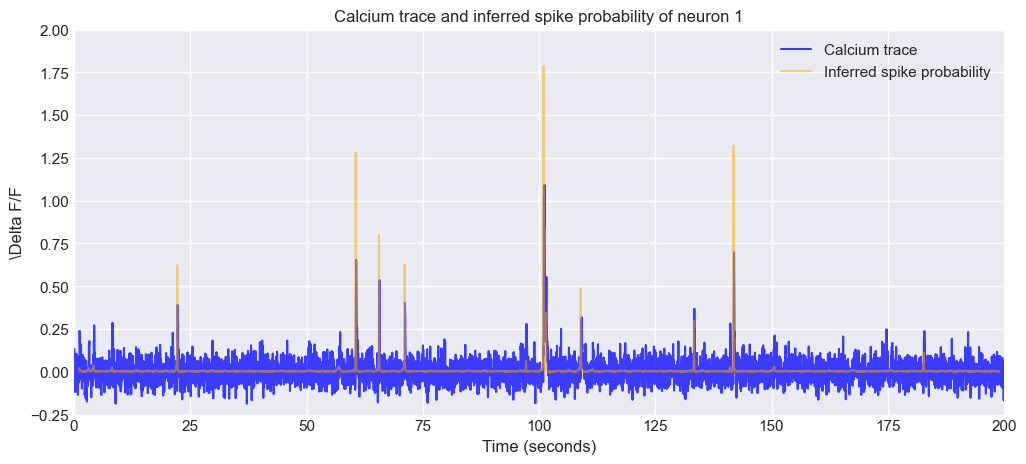

In [30]:
neuron_i = 0

# define a time array based on the frame_rate:
time_vector = np.arange(traces.shape[1]) / frame_rate

# plot the calcium trace and the inferred spike probability for the selected neuron:
plt.figure(figsize=(12, 5))
plt.plot(time_vector, traces[neuron_i, :], c="blue", alpha=0.75, label='Calcium trace')
plt.plot(time_vector, spike_prob[neuron_i, :], alpha=0.5, c="orange", label='Inferred spike probability')
plt.xlabel('Time (seconds)')
plt.ylabel(f'\Delta F/F')
plt.xlim(0, time_vector[-1])
plt.ylim(-0.25, 2)
plt.title(f'Calcium trace and inferred spike probability of neuron {neuron_i + 1}')
plt.legend()
plt.show()

**Exercise:** Again, play around with the neuron indices variable `neuron_i` to plot different neurons and assess your results. What do you notice? How well does the inferred spike probability match the calcium trace? Are there any discrepancies or unexpected patterns? 

Of course, we can also again use CASCADE's plotting functions to visualize the traces and the inferred spike probabilities:

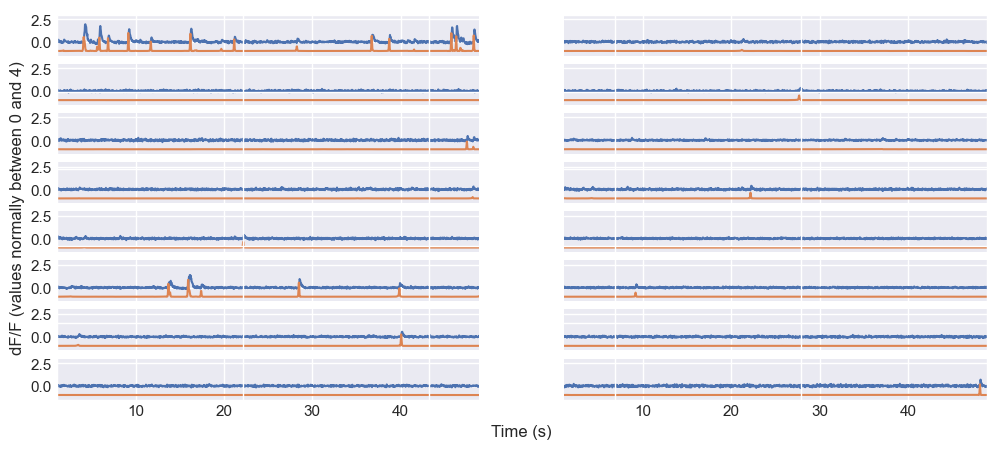

In [32]:
# By default plots a set of 16 randomly chosen neuronal traces (first seconds). 
# The dF/F traces are shown in blue, the inferred spike probability is plotted in orange 
# (shifted downwards by 1 for better visibility).

N_neurons = 16

neuron_indices = np.random.randint(traces.shape[0], size=N_neurons)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate,spike_prob,y_range=(-1.5, 3))

## Save predictions to output file
We now have the option, to save our predicted spike probabilities to an output file. Below are a few examples of how to do this:

In [101]:
# create a folder path, that is two levels above the current working directory:
folder_path = os.path.dirname(os.getcwd())
file_name = 'predictions_' + os.path.splitext( os.path.basename(example_file))[0]
save_path = os.path.join(folder_path, file_name)

# save as csv file:
np.savetxt(save_path+'.csv', spike_prob, delimiter=',', fmt='%.6f')

# save as mat file:
#sio.savemat(save_path+'.mat', {'spike_prob':spike_prob})

# save as numpy file:
# np.save(save_path, spike_prob)



## Exercise: Load and analyze your own $\Delta F/F$ traces
Now it's time, the load and plot $\Delta F/F$ traces we have derived from our CaImAn analysis. 

First, open the created csv file with the your default spreadsheet software (e.g. Excel, LibreOffice Calc) and check the format of the data. You will notice that the file is structured as a table with the following columns: time, neuron_1, neuron_2, ..., neuron_n. Each row corresponds to a time point, and each column corresponds to a neuron. The values in the table are the $\Delta F/F$ values for each neuron at each time point.
Next, we need to load the data into a NumPy array. We can use the `np.loadtxt` function to load the data from the CSV file:

In [97]:
# let's load the saved csv file from our CaImAn analysis:
csv_file_folder_path = os.path.join(os.getcwd() , '../../01 CaImAn tutorial')
csv_file_path = os.path.join(csv_file_folder_path, 'Sue_2x_3000_40_-46_C_traces.csv')

# use np.loadtxt:
my_traces = np.loadtxt(csv_file_path, delimiter=',', skiprows=1)

Let's inspect the shape of the loaded data:

In [88]:
print(f"Shape of loaded dF/F traces: {my_traces.shape}")

Shape of loaded dF/F traces: (3000, 66)


The shape of `(3000, 66)` indicates that we have 3000 time points and 66 neurons. Since CASCADE expects the data in the shape `(neurons, time)`, we need to transpose the array to match this format:

In [89]:
my_traces = my_traces.T
print(f"Shape of loaded dF/F traces: {my_traces.shape}")

Shape of loaded dF/F traces: (66, 3000)


Next, we need to remove the first column, which contains the time points, and keep only the $\Delta F/F$ values. We can do this by slicing the array:

In [90]:
my_traces = my_traces[1:,:]
print(f"Shape of loaded dF/F traces: {my_traces.shape}")

Shape of loaded dF/F traces: (65, 3000)


Also, remember that CASCADE expects the $\Delta F/F$ traces range between 0 and 1 and not in percent (e.g. 0.5 instead of 50%). If your data is in percent, you need to divide the values by 100 – and this is the case for our data:

In [91]:
np.max(my_traces)

5190.636617511848

In [92]:
my_traces = my_traces / 100.0

In [93]:
np.max(my_traces)

51.906366175118485

Let's plot the trace of the first neuron to see what it looks like:

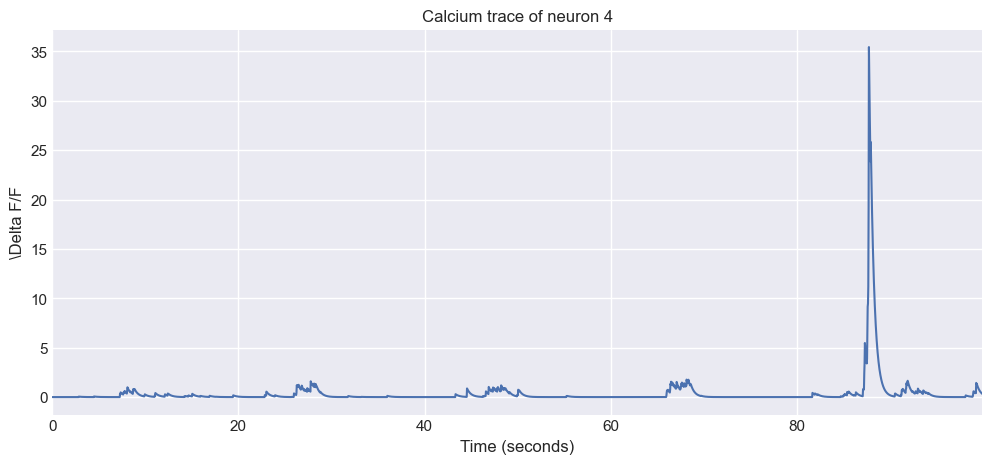

In [94]:
# define the frame rate of your own data:
frame_rate = 30  # fps

# define the neuron index to plot:
neuron_i = 3

# define a time array based on the frame_rate:
time_vector = np.arange(my_traces.shape[1]) / frame_rate

# plot the calcium trace for the selected neuron:
plt.figure(figsize=(12, 5))
plt.plot(time_vector, my_traces[neuron_i, :])
plt.xlabel('Time (seconds)')
plt.ylabel(f'\Delta F/F')
plt.xlim(0, time_vector[-1])
plt.title(f'Calcium trace of neuron {neuron_i + 1}')
plt.show()

After ensuring that the data is in the correct format, you can proceed with the running CASCADE on your own data. To do so:

1. Scroll up to the cell indicated by the comment `# THIS CELL/STEP IS RESERVED FOR THE EXERCISE` and overwrite the `traces` variable with your own data (e.g. `traces = my_traces`).
2. Proceed with all subsequent cells as they are. Adjust the frame rate setting according to your data. Also, find a suitable pre-trained model for your data, as described in the previous sections.

## CASCADE Frequently Asked Question
I kept the original FAQ section from the CASCADE demo notebook, which contains important information about the algorithm and its output. 

#### What does the output of the algorithm mean?

>The output **spike_prob** is the _expected number of spikes_ in this time bin, at the same resolution as the original calcium recording. This metric is also called _spike probability_ for brevity in the paper and elsewhere. If you sum over the trace in time, you will get the estimated **number of spikes**. If you multiply the trace with the frame rate, you will get an estimate of the instantaneous **spike rate**. Spike probability and spike rates can therefore be converted by multiplication with the frame rate.

#### Can **spike_prob** be larger than 1?

>Yes. As described above ("What does the output of the algorithm mean?"), the output of the algorithm is strictly speaking not a probability and therefore not restricted to values between 0 and 1. A value >1 indicates that the estimated number of spikes in the time bin is larger than 1.

#### How large would a single spike be?
>This depends on your **frame rate** (Hz) and on the **smoothing** (milliseconds) of your model. Use the following script to compute how the inferred spike probability shape would look like for a single isolated spike for given parameters.
>
>**Smoothing** is the standard deviation of the Gaussian used to smooth the ground truth spike rate before it is used for training. In the file name of a pretrained model, the smoothing parameter is indicated. Read below for more details.




In [95]:
from scipy.ndimage.filters import gaussian_filter
import numpy as np

sampling_rate = 30 #@param {type:"number"}
smoothing = 50 #@param {type:"number"}

# find out empirically  how large a single AP is
single_spike = np.zeros(1001,)
single_spike[501] = 1
single_spike_smoothed = gaussian_filter(single_spike.astype(float), sigma=smoothing/1e3*sampling_rate)

gaussian_amplitude = np.round(np.max(single_spike_smoothed)*1000)/1000

gaussian_width = np.round(2*np.sqrt(2*np.log(2))*smoothing/1e3*100)/100


print('A single spike in the predictions will have an amplitude of '+str(gaussian_amplitude)+' and a width (FWHM) of '+str(gaussian_width)+' seconds.')


A single spike in the predictions will have an amplitude of 0.266 and a width (FWHM) of 0.12 seconds.


#### How precise and good are my predictions?

>This depends mainly on the **shot noise level** of your dataset. If you want to compute how well the chosen model generalizes to unseen data for a given noise level, check out the Github repository and use [the demo script](https://github.com/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Demo_benchmark_model.py) which computes the performance of a given model.
>
>To get a good idea about the quality of predictions to unseen data, check out **Figure 3** and the associated discussion in the [paper](https://www.nature.com/articles/s41593-021-00895-5).

#### Why is the output of the algorithm a probability, why not discrete spikes?

>Good question! We think that providing spike times instead of spike rates or spiking probabilities is misleading, since it suggests a false precision and certainty of the spiking estimates. In addition, we found (**Fig. S7** in the [paper](https://www.nature.com/articles/s41593-021-00895-5)) that single-spike precision could not achieved with any of the ground truth datasets.
>
>However, for some cases, discrete spikes still might be a good approach. We provide a Python function that converts the spiking probability into the most likely underlying discrete spikes (**[demo](https://github.com/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Demo_discrete_spikes.py)** on Github).


#### Why are the first and last datapoints of the predictions NaNs?

>The deep network uses a window that looks at the calcium trace around the current time point to better understand the context of the current time point. For the first and last points in time, the network is unable to look into the environment and therefore gives back NaNs. If the window size of the network is 64 datapoints (which is the default), the first and last 32 time points will be NaNs.


#### I get a certain noise level for my recordings. What is good or bad?

>For an illustration of different noise levels, check out Extended Data Fig. 3 in the [paper](https://www.nature.com/articles/s41593-021-00895-5). To give an example, the Allen Brain Observatory Visual Coding dataset is of very high imaging quality, with noise levels around **1, which is very good** (unit: $\small \%·s^{-1/2}$ ). A noise level of **3-4 is still decent**, especially for population imaging with many neurons. Noise levels **above 5 indicates rather poor signal** levels. For a definition of the noise level, check out the Methods of the preprint.
>
>However, even for excellent shot noise levels, the recording quality can be bad due to bad imaging resolution, **neuropil contamination** and, most importantly, **movement artifacts**. See Extended Data Fig. 5 in the [paper](https://www.nature.com/articles/s41593-021-00895-5) and the associated text as well as the Discussion for more details.


#### How do I select an appropriate model for my data?

> Each model is trained on a resampled ground truth dataset, as described in the preprint. The training dataset is resampled at the desired frame rate and at multiple noise levels. The model automatically chooses the model with matching noise-levels for each neuron. You only have to select the correct frame rate (which is indicated in the model name).
>
>If you do not have a specific ground truth for your dataset, it is typically best (see Fig. 3 and the associated discussion in the [paper](https://www.nature.com/articles/s41593-021-00895-5)) to use a model that has been trained on all available datasets (called 'Global EXC Model').
>
>There are two additional model specifications that you can choose, "causal" kernels and "smoothing". The choice of these specifications does not make a model better or worse, but better or less well suited for your needs. See the following two questions!

#### What does the **smoothing** parameter for the models mean?

> The ground truth which has been used to train the model has been slightly smoothed with a Gaussian kernel. This is a processing step which helps the deep network to learn quicker and more reliably. However, this also means that the predictions will be smoothed in a similar fashion. How to choose these parameters optimally?
>
> From our experience, at a frame rate of 7.5 Hz, a smoothing kernel with standard deviation of 200 ms is appropriate; for nicely visible transients, also a value of 100 or 50 ms can be tried out, and we have had cases where this was the most satisfying choice of parameters. At 30 Hz, a smoothing kernel of 50 ms works well, but a smoothing kernel of 25 ms could be tried as well if the data quality is good and if one wants to avoid temporally smooth predictions. If the calcium imaging quality is not ideal, it can make sense to increase the smoothing kernel standard deviation. In the end, it is always a trade-off between reliability and optimal learning (more smoothing) and temporal precision (less smoothing of the ground truth). The impact of temporal smoothing on the quality of the inference is discussed in Extended Data Fig. 9 in the [paper](https://www.nature.com/articles/s41593-021-00895-5).
>
> However, if you use our suggested default specifications and your results look useful, you should be good!


#### What does the "causal" mean for some of the models?

> By default, the ground truth is smoothed symmetrically in time. This means, also the predicted spike probabilities are symetrically distributed in time around the true time point. In some cases, this can be a problem because this predicts non-zero neuronal spiking probability before the calcium event had even started. Especially when you want to analyze stimulus-triggered activity patterns, this is an important issue and a common problem for all deconvolution algorithms.
>
> However, if the ground truth is smoothed not with a symmetric Gaussian but with a smooth causal kernel, this limitation can be circumvented (discussed in detail in Fig. S12 in the [paper](https://www.nature.com/articles/s41593-021-00895-5)), and spiking activity is almost exclusively assigned to time points after the calcium event started. It must be noted that this reliable causal re-assignment of activity works well for high-quality datasets, but in case of higher noise levels, any deconvolution algorithm will assign activity to non-causal time points. Good to keep in mind when you interpret your results!


#### None of the models is good for me. What can I do?

> First of all, is this really true? For example, if you have recorded at 30.5 Hz, you can also use a model trained at 30 Hz imaging rates. A deviation by less than 5\% of the imaging rate is totally okay in our experience!
>
> If however you want to use an entirely different model, for example a model trained at a sampling rate of 2 Hz, or a model only trained with a specific ground truth dataset, you have two options. 1) You go to the [Github page](https://github.com/HelmchenLabSoftware/Cascade) and follow the instructions on how to train you own model. This can be done even without GPU-support, but it will take some time (on the other hand, you only have to do this once). 2) You contact us via [e-Mail](mailto:p.t.r.rupprecht+cascade@gmail.com) and tell us what kind of model you would like to have. We will train it for you and upload it to our repository. Not only you, but everybody will then be able to use it further on.



#### I have my own ground truth dataset. How can I use it?

> You have two options.
>
> Either you process the data yourself. You can inspect the ground truth datasets, which consist of Matlab structs saved as a file for each neuron from the [ground truth](https://github.com/HelmchenLabSoftware/Cascade/tree/master/Ground_truth). If you process your ground truth recordings into the same format, you can use it as a training set and train the model yourself. Detailed instructions are provided in the [Github repository](https://github.com/HelmchenLabSoftware/Cascade).
>
> Or you can contact us, and we help to process your dataset if it meets certain quality standards. We can process raw calcium and ephys recordings, but if you can provide extracted dF/F traces and spike times this would of course be even better. Yes, we will do the work for you. But only under the condition that the processed dataset will then be integrated into the published set of ground truth datasets, where it is openly accessible to everybody. Please get in touch with us to discuss options on how to get credit for the recording of the dataset, which we will discuss case by case.

#### I want to use my own ground truth dataset, but I don't want to share it.

> As mentioned, you can process the ground truth dataset yourself. However, we will only help you with the dataset is made public afterwards.


#### Can I use Cascade also locally, *e.g.*, within [CaImAn](https://github.com/flatironinstitute/CaImAn), or in my own pipeline?

> Sure! We have done this ourselves with CaImAn and our custom analysis pipelines. Your starting point to do this will not be this Colaboratory Notebook, but rather the [Github repository](https://github.com/HelmchenLabSoftware/Cascade). Check out the demo Python scripts (*.py). They are very easy to understand and will show you which functions you have to use and how. If you have successfully used this Colaboratory Notebook, understanding the demo scripts will be a piece of cake.

#### Can I use Cascade as well for endoscopic 1p calcium imaging data?

> One of the key features of Cascade is that it infers absolute spike rates. To achieve this, it is necessary that dF/F values extracted from neuronal ROIs are approximately correct. For endoscopic 1p calcium imaging data, the background fluorescence is typically extremely high, and complex methods for subtraction of global or local background activity are used (e.g., by [CNMF-E](https://elifesciences.org/articles/28728)). As also discussed in the CNMF-E paper, extraced traces therefore cannot be properly transformed into dF/F values. We therefore do not recommend Cascade for the deconvolution of this kind of dataset. A purely linear deconvolution algorithm that does not reflect the absolute scaling of the input would be a better choice in such a case, if deconvolution is required.

#### I would like to look at the ground truth data.

> We actually recommend this to anybody who is doing calcium imaging at cellular resolution. Looking at the ground truth data of simultaneous calcium and juxtacellular recording is very enlightening. In the [Github repository](https://github.com/HelmchenLabSoftware/Cascade), we have written an interactive tool to conveniently visualize all ground truth datasets, it is available as a [Colaboratory Notebook](https://colab.research.google.com/github/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Explore_ground_truth_datasets.ipynb).
>
> We recommend to browse through these datasets to any person doing calcium imaging.



#### Which reference should I cite?


> Please cite the [paper](https://www.nature.com/articles/s41593-021-00895-5) as a reference for Cascade:
>
> Rupprecht P, Carta S, Hoffmann A, Echizen M, Blot A, Kwan AC, Dan Y, Hofer SB, Kitamura K, Helmchen F\*, Friedrich RW\*, *A database and deep learning toolbox for noise-optimized, generalized spike inference from calcium imaging*, Nature Neuroscience (2021).
>
> (\* = co-senior authors)
>
>.
>
> If you use the respective ground truth datasets directly, please also refer to the original papers and the associated dataset:
>
> Rupprecht P, Carta S, Hoffmann A, Echizen M, Blot A, AC Kwan, Dan Y, Hofer SB, Kitamura K, Helmchen F\*, Friedrich RW\*, *A database and deep learning toolbox for noise-optimized, generalized spike inference from calcium imaging*, Nature Neuroscience (2021), for datasets \#3-8, \#19 and \#27.
>
> Schoenfeld G, Carta S, Rupprecht P, Ayaz A, Helmchen F, *In vivo calcium imaging of CA3 pyramidal neuron populations in adult mouse hippocampus*, eNeuro (2021), for dataset \#18.
>
> Chen TW, Wardill TJ, Sun Y, Pulver SR, Renninger SL, Baohan A, Schreiter ER, Kerr RA, Orger MB, Jayaraman V, Looger LL. *Ultrasensitive fluorescent proteins for imaging neuronal activity*, Nature (2013), for datasets \#9 and \#14.
>
> Huang L, Ledochowitsch P, Knoblich U, Lecoq J, Murphy GJ, Reid RC, de Vries SE, Koch C, Zeng H., Buice MA, Waters J, Lu Li, *Relationship between simultaneously recorded spiking activity and fluorescence signal in GCaMP6 transgenic mice*, eLife (2021), for datasets \#10, \#11, \#12 and \#13.
>
> Berens P, et al. *Community-based benchmarking improves spike rate inference from two-photon calcium imaging data*, PLoS Comp Biol (2018), for datasets \#1, \#15, \#16.
>
> Akerboom J, Chen TW, Wardill TJ, Tian L, Marvin JS, Mutlu S, Calderón NC, Esposti F, Borghuis BG, Sun XR, Gordus A. *Optimization of a GCaMP calcium indicator for neural activity imaging*, J Neuroscience (2012), for dataset \#17.
>
> Bethge P, Carta S, Lorenzo DA, Egolf L, Goniotaki D, Madisen L, Voigt FF, Chen JL, Schneider B, Ohkura M, Nakai J. *An R-CaMP1.07 reporter mouse for cell-type-specific expression of a sensitive red fluorescent calcium indicator*, PloS ONE (2017), for dataset \#19.
>
> Tada M, Takeuchi A, Hashizume M, Kitamura K, Kano M. *A highly sensitive fluorescent indicator dye for calcium imaging of neural activity in vitro and in vivo*, EJN (2014), for dataset \#3.
>
> Dana H, Mohar B, Sun Y, Narayan S, Gordus A, Hasseman JP, Tsegaye G, Holt GT, Hu A, Walpita D, Patel R. *Sensitive red protein calcium indicators for imaging neural activity*, Elife (2016), for datasets \#20 and \#21.
>
> Khan AG, Poort J, Chadwick A, Blot A, Sahani M, Mrsic-Flogel TD, Hofer SB. *Distinct learning-induced changes in stimulus selectivity and interactions of GABAergic interneuron classes in visual cortex*, Nature Neuroscience (2018), for datasets \#24-26.
>
> Kwan AC, Dan Y. *Dissection of cortical microcircuits by single-neuron stimulation in vivo*, Current Biology (2012), for datasets \#2 and \#22-23.
